# `mle-logging`: A Lightweight Logger for ML Experiments 📖
### Author: [@RobertTLange](https://twitter.com/RobertTLange) [Last Update: January 2022] [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mle-infrastructure/mle-logging/blob/main/examples/getting_started.ipynb)

There are few things that bring me more joy, than automating and refactoring code, which I use on a daily basis. It feels empowering (when done right) and can lead to some serious time savings. The motto: 'Let's get rid of boilerplate'. One key ingredient to my daily workflow is the logging of neural network training learning trajectories and their diagnostics (predictions, checkpoints, etc.). There are many ways to do this: At the beginning of a project you may only save lists of training/validation/test losses to `.csv` files. After an initial prototype you may switch to a tensorboard setup. Maybe with a time string in front of the filename. But this can become annoying as one wants to compare runs across hyperparameters configurations and aggregate statistics across random seeds. This leads to a fundamental question: **What makes a good logger for Machine Learning Experiments (MLE)?** After looking at some of my previous projects, I drafted a list of desired properties:

1. **Generality**: The logger should support different types of experiments (multi-seed/multi-configuration) and provide the functionality to store/retrieve their key diagnostics. This includes time-series statistics such as losses or predictive accuracy, network checkpoints of various flavors, generated figures as well as any other objects one might want to save over the course of training.
2. **Reproducibility**: The logger should provide all the necessary information in order to reproduce the statistics stored within it. This includes the hyperparameter configuration and random seed of the trained pipeline.
3. **Integratability**: Given that we may want to search over hyperparameters and rerun experiments over multiple random seeds, the logger has to be able to easily combine these different sub-logs. Furthermore, fetching an individual run should not be challenging.
4. **Usability**: The API has to pleasant and intuitive to use. The log aggregation should require a minimal amount of information regarding the file locations. Plotting individual results should work seamlessly. Finally, it has to be easy to continue a previously interrupted experiment. 

Now you may say: "Rob, [Weights&Biases](https://wandb.ai/) provide an awesome service that you may be interested in." And that is certainly true - W&B is awesome. But I am a big fan of simple file systems, which are easily accessible so that loading of results and model checkpoints for post-processing are smooth. Finally, I don't always want to carry around login keys on remote VMs. (Note: I also like to be in low-level control). Based on these considerations and some iterations I came up with the following simple `MLELogger` design: 

![](https://github.com/mle-infrastructure/mle-logging/blob/main/docs/mle_logger_structure.png?raw=true)

Let's now walk through the individual logging steps, how to visualize & reload the log and how to aggregate multiple logs across random seeds and configurations:

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

#!pip install -q mle-logging
try:
    from mle_logging import MLELogger
except:
    !pip install -q mle-logging
    from mle_logging import MLELogger

# Storing Basic Logging Results (Stats, Checkpoints, Plots)

We start by creating an instance of the `MLELogger`. The logger takes a set of minimal inputs: `time_to_track`, `what_to_track`. They are both lists of strings which provide the time and statistic variable names, we want to log over time. There are a couple more optional basic ingredients:

| Argument                   |            Type            |        Description                                             |
| -------------------------- | -------------------------- | -------------------------------------------------------------- |
| **`experiment_dir`**       | str         | Base directory in which you want to store all your results in. |
| **`config_fname`**         | str                      | Filename of `.json` configuration (to be copied into the `experiment_dir`).  |
| **`config_dict`** | dict | Dictionary of experiment configuration to store in yaml file.
| **`seed_id`**         | int                      | Random seed of experiment run.  |
| **`model_type`**           | str                           | Specify model type (`jax`, `torch`, `tensorflow`, `sklearn`, `numpy`) to save.|
| **`use_tboard`**           | bool              | Boolean indicating whether to log statistics also to TensorBoard.       |
| **`overwrite`**            | bool             | Whether to overwrite/replace a previously stored log.       |
| **``verbose``**            | bool              | Whether to print out the most recent updates and logger setup.       |
| **`time_to_print`**        | List[str]              | Subset of time variables to print out onto the console.|
| **`what_to_print`**        | List[str]              | Subset of stats variables to print out onto the console.|
| **`print_every_k_updates`**  | int            | How often to print the updated statistics.           |

In [31]:
# Instantiate logging to experiment_dir
log = MLELogger(experiment_dir="experiment_dir/",
                config_dict={"train_config": {"lrate": 0.01}},
                use_tboard=False,
                model_type='torch',
                print_every_k_updates=1,
                verbose=True)

╭──────────────────────────────────────────────────────────────────────────────╮
│  __    __  __      ______  __      ______  ______          08/01/22 13:33:56 │
│ /\ "-./  \/\ \    /\  ___\/\ \    /\  __ \/\  ___\          Logger v0.0.4 🔏 │
│ \ \ \-./\ \ \ \___\ \  __\  \ \___\ \ \/\ \ \ \__ \         ]8;id=310925;https://twitter.com/RobertTLange\@RobertTLange]8;;\ 🐦 │
│  \ \_\ \ \_\ \_____\ \_____\ \_____\ \_____\ \_____\         ]8;id=490995;https://github.com/RobertTLange/mle-logging/blob/main/examples/getting_started.ipynb\MLE-Log Docs]8;;\ 📓 │
│   \/_/  \/_/\/_____/\/_____/\/_____/\/_____/\/_____/         ]8;id=545591;https://github.com/RobertTLange/mle-logging/\MLE-Log Repo]8;;\ 📝 │
╰──────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────────────────────────────────╮
│ ╭──────────────────────────────────────────────╮╭──────────────────────────╮ │
│ │ 📖 Log Dir: experiment_dir/                  ││ 📄 Config: None          │ │
│ ╰──────────────────────────────────────────────╯╰──────────────────────────╯ │
│ ╭──────────────────────────────────────────────╮╭──────────────────────────╮ │
│ │ ⌚ Time:                                     ││ 📉 Stats:                │ │
│ ╰──────────────────────────────────────────────╯╰──────────────────────────╯ │
│ ╭──────────────────────────────────────────────╮╭──────────────────────────╮ │
│ │ 🌱 Seed ID: no_seed_provided                 ││ 🚀 Model: torch          │ │
│ ╰──────────────────────────────────────────────╯╰──────────────────────────╯ │
╰──────────────────────────────────────────────────────────────────────────────╯

We can then simply log some a time-series "tick"/timestamp by providing the key, value pairs to `log.update()`. The log will print the last provided statistics using `rich` formatting:

In [32]:
# Save some time series statistics
time_tic = {'num_steps': 10, 'num_epochs': 1}
stats_tic = {'train_loss': 0.1234, 'test_loss': 0.1235}

# Update the log with collected data & save it to .hdf5
log.update(time_tic, stats_tic)
log.save()

                                                                                
  ⌚ time      time_el…   num_upd…   num_ste…   num_ep…       📉       test_l…  
                                                          train_loss            
 ────────────────────────────────────────────────────────────────────────────── 
  22-01-08/…   1.33421…      1          10         1        0.123       0.124   
                                                                                

Furthermore, we can save the most current checkpoint via `log.save_model()`. Here is an example for how to store a torch model checkpoint:

In [33]:
# Save a model (torch, sklearn, jax, numpy)
import torch.nn as nn

class DummyModel(nn.Module):
    def __init__(self):
        super(DummyModel, self).__init__()
        self.fc1 = nn.Linear(28*28, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
    
model = DummyModel()
log.save_model(model)

If you would like to save a figure that was generated during your training loop, this can be done via `log.save_plot()`. More general objects can be saved as `.pkl` via `log.save_extra`. The log will keep a counter of how many figures or objects were previously saved. If you do not provide an explicit path to the function calls, this counter will be used to archive the files chronologically.

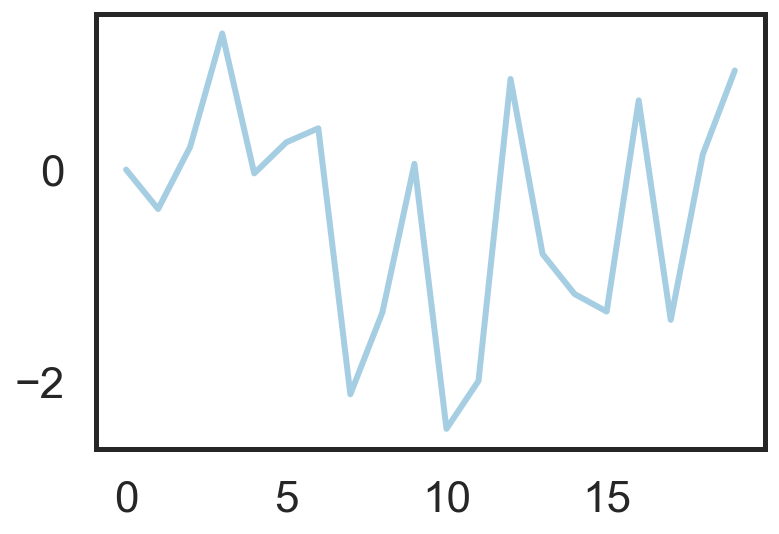

In [34]:
# Save a matplotlib figure as .png
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(np.random.normal(0, 1, 20))
log.save_plot(fig)
# You can also explicity give a name to the file
# log.save_plot(fig, "some_figure_path.png")

# You can also save (somewhat) arbitrary objects .pkl
some_dict = {"hi": "there"}
log.save_extra(some_dict)

# You can also explicity give a name to the file
# log.save_extra(some_dict, "some_object_path.pkl")

And obviously you do not need to go through these steps individually, but can also save statistics, model checkpoint, a plot and extra content all in one go: 

In [35]:
# Or do everything in one go
log.update(time_tic, stats_tic, model, fig, some_dict, save=True)

                                                                                
  📩 - Figure    experiment_dir/figures/fig_2_no_seed_provided.png              
  📩 - Extra     experiment_dir/extra/extra_2_no_seed_provided.pkl              
                                                                                

                                                                                
  22-01-08/…   9.66433…      2          10         1        0.123       0.124   
                                                                                

# Reloading for Post-Processing

If your experiments finished and you would like to perform some post-processing, you can load the results via `load_log(<experiment_dir>)`. The reloaded log is a `dotmap` dictionary, which has three subkeys: 

1. `meta`: The meta-information of the experiment. This includes random seed, configuration path, figure paths, experiment directory, etc..
2. `time`: The time-series for the `time` variables.
3. `stats`: The time-series for the `stats` variables.

The individual data can be accessed via indexing with `.` - have a look:

In [36]:
from mle_logging import load_log

log = load_log("experiment_dir/")
log.meta

['no_seed_provided']


DotMap(config_dict={'train_config': {'lrate': 0.01}}, config_fname='experiment_dir/config_dict.yaml', eval_id=[], experiment_dir='experiment_dir/', extra_storage_paths=['experiment_dir/extra/extra_1_no_seed_provided.pkl', 'experiment_dir/extra/extra_2_no_seed_provided.pkl'], fig_storage_paths=['experiment_dir/figures/fig_1_no_seed_provided.png', 'experiment_dir/figures/fig_2_no_seed_provided.png'], log_paths='experiment_dir/logs/log_no_seed_provided.hdf5', model_ckpt='experiment_dir/models/final/final_no_seed_provided.pt', model_type='torch')

In [37]:
log.stats.keys(), log.stats.test_loss

(odict_keys(['test_loss', 'train_loss']),
 array([0.1235, 0.1235], dtype=float32))

In [38]:
log.time.keys(), log.time.num_updates

(odict_keys(['num_epochs', 'num_steps', 'num_updates', 'time', 'time_elapsed']),
 array([1., 2.], dtype=float32))

# Reloading And Resuming An Interrupted Experiment

It can also happen that an experiment was interrupted. Your Colab runtime may run out or for some reason your VM gets interrupted. In that case you would like to be able to resume your experiment and continue to update the log. This can be simply be achieved by using the option `reload=True` and by reloading the previously stored checkpoint:

In [43]:
# Instantiate logging to experiment_dir
log = MLELogger(experiment_dir="experiment_dir/",
                use_tboard=True,
                model_type='torch',
                verbose=True,
                reload=True)

log.stats_log.clock_tracked

[13:45:29] Reloaded log from experiment_dir/                                     ]8;id=644181;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-logging/mle_logging/utils/comms.py\comms.py]8;;\:]8;id=413202;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-logging/mle_logging/utils/comms.py#178\178]8;;\

{'num_epochs': [1.0, 1.0],
 'num_steps': [10.0, 10.0],
 'num_updates': [1.0, 2.0],
 'time': [b'22-01-08/13:33', b'22-01-08/13:34'],
 'time_elapsed': [1.3342180252075195, 9.664338111877441]}

In [44]:
log.update(time_tic, stats_tic, model, fig, some_dict, save=True)
log.stats_log.stats_tracked

                                                                                
  📩 - Figure    experiment_dir/figures/fig_4_no_seed_provided.png              
  📩 - Extra     experiment_dir/extra/extra_4_no_seed_provided.pkl              
  📩 - Model     experiment_dir/models/final/final_no_seed_provided.pt          
                                                                                

                                                                                
  ⌚           num_ste…   num_upd…     time     time_e…       📉       train_…  
  num_epochs                                              test_loss             
 ────────────────────────────────────────────────────────────────────────────── 
  1               10        3.0      22-01-0…   1.0896…     0.124       0.123   
                                                                                

AttributeError: 'StatsLog' object has no attribute 'stats_to_track'

# Ad-Hoc Plotting of Results

Let's say you have trained a neural network and are now ready to dive into the nitty gritty details. What do you do first? Take a look at your learning curves:

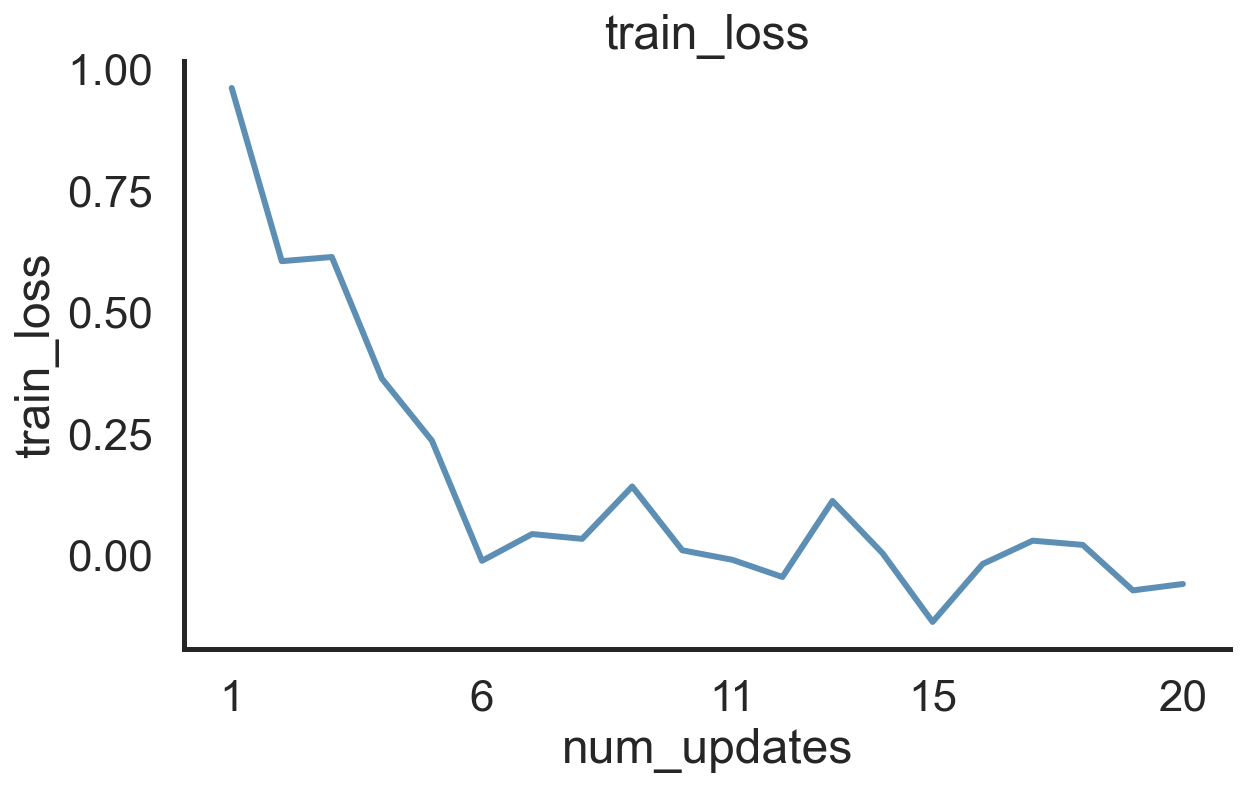

In [45]:
log = MLELogger(time_to_track=['num_updates', 'num_epochs'],
                what_to_track=['train_loss', 'test_loss'],
                experiment_dir="post_plot_dir/")

for step in range(20):
    log.update({'num_updates': step+1, 'num_epochs': 0},
               {'train_loss': np.exp(-0.5*step) + np.random.normal(0, 0.1),
                'test_loss': np.exp(-0.3*step)  + np.random.normal(0, 0.1)}, save=True)

# Load in the log and do a quick inspection of the training loss
log = load_log("post_plot_dir/")
fig, ax = log.plot('train_loss', 'num_updates')

# Log Different Random Seeds for Same Configuration

If you provide a `.json` file path and a seed_id, the log will be created in a sub-directory. Furthermore, the `.json` file will be copied for reproducibility. Multiple simultaneous runs (different seeds) can now log to the same directory. Everything else remains the same.

In [ ]:
# Check if code is run in Colab: If so -- download configs from repo
try:
    import google.colab
    IN_COLAB = True
    !wget https://raw.githubusercontent.com/mle-infrastructure/mle-logging/main/examples/config_1.json
    !wget https://raw.githubusercontent.com/mle-infrastructure/mle-logging/main/examples/config_2.json
except:
    IN_COLAB = False

In [49]:
# Instantiate logging to experiment_dir for two random seeds
log_seed_1 = MLELogger(experiment_dir="multi_seed_dir/",
                       config_fname="config_1.json",     # Provide path to .json config
                       seed_id=1)                        # Provide seed int identifier  

log_seed_2 = MLELogger(experiment_dir="multi_seed_dir/",
                       config_fname="config_1.json",     # Provide path to .json config
                       seed_id=2)                        # Provide seed int identifier  

# Save some time series statistics
for step in range(20):
    log_seed_1.update({'num_updates': step+1, 'num_epochs': 0},
                      {'train_loss': np.exp(-0.5*step) + np.random.normal(0, 0.1),
                       'test_loss': np.exp(-0.3*step)  + np.random.normal(0, 0.1)}, save=True)
    log_seed_2.update({'num_updates': step+1, 'num_epochs': 0},
                      {'train_loss': np.exp(-0.5*step) + np.random.normal(0, 0.1),
                       'test_loss': np.exp(-0.3*step)  + np.random.normal(0, 0.1)}, save=True)

We can then use `merge_seed_logs` in order to combine both `.hdf5` log files (for the different seeds) into a single file stored in `merged_path`. The `load_log` function afterwards will load this seed-merged log and the first level of the `dotmap` dictionary will give you an overview of the different random seeds: 

In [50]:
import os
from mle_logging import merge_seed_logs, load_log

experiment_dir = f"multi_seed_dir/config_1/"
merged_path = os.path.join(experiment_dir, "logs", "seed_aggregated.hdf5")

# Merge different random seeds into one .hdf5 file
merge_seed_logs(merged_path, experiment_dir)

(['seed_1', 'seed_2'],
 array([ 0.96705544,  0.6083728 ,  0.46182477,  0.15633751,  0.01732348,
         0.27786434, -0.07685427,  0.01918761, -0.03659077,  0.00186389,
         0.09945649,  0.06629274,  0.09570506, -0.10840558,  0.01095656,
         0.12027647,  0.00841762, -0.01696181,  0.22844663, -0.04534577],
       dtype=float32),
 (<Figure size 648x432 with 1 Axes>,
  <AxesSubplot:title={'center':'train_loss'}, xlabel='num_updates', ylabel='train_loss'>))

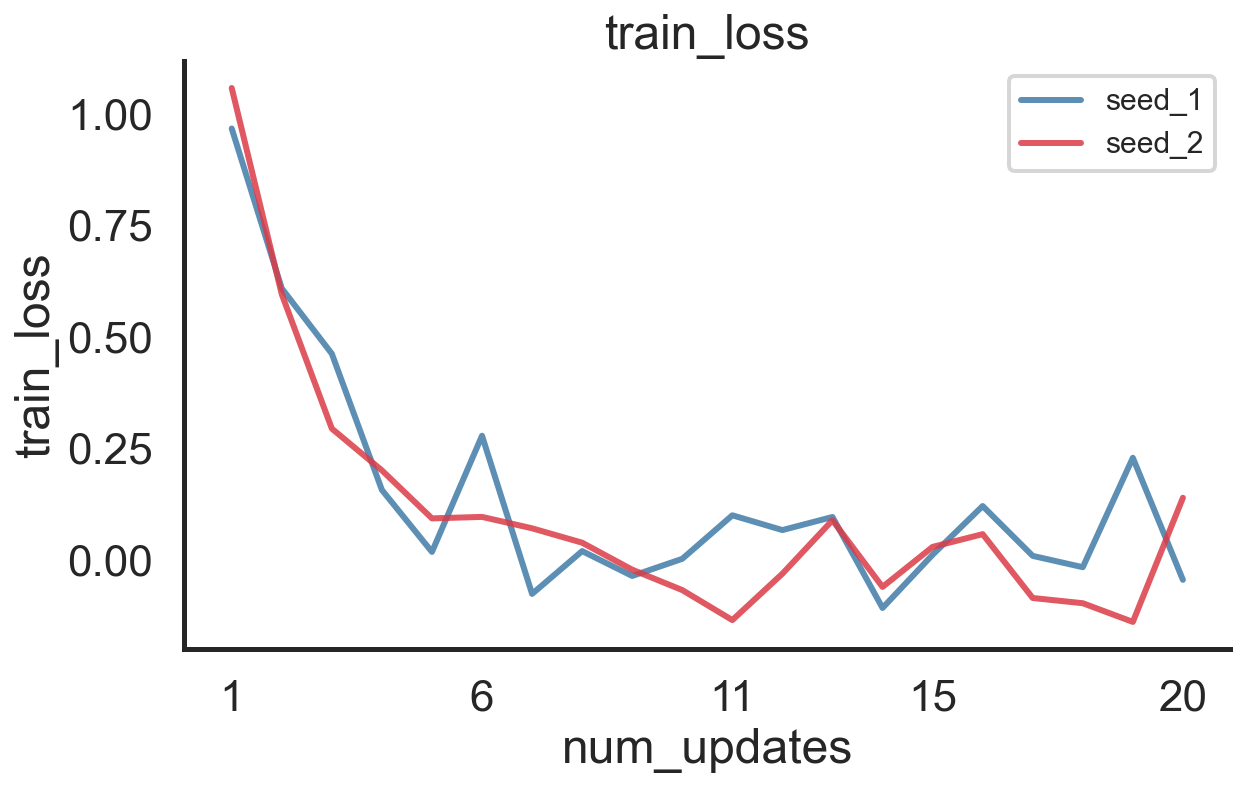

In [51]:
# Load the merged log - Individual seeds can be accessed via log.seed_1, etc.
log = load_log(experiment_dir)
log.eval_ids, log.seed_1.stats.train_loss, log.plot('train_loss', 'num_updates')

You can also directly aggregate these different random seeds by setting `aggregate_seeds=True`. This will compute the mean, standard deviation as well as different percentiles over the random seeds.

DotMap(config_dict={'train_config': {'lrate': 0.1}, 'model_config': {'num_layers': 5}, 'log_config': {'time_to_track': ['step_counter'], 'what_to_track': ['loss'], 'time_to_print': ['step_counter'], 'what_to_print': ['loss'], 'print_every_k_updates': 10, 'overwrite_experiment_dir': 1}}, config_fname='multi_seed_dir/config_1/config_1.json', eval_id='config_1', experiment_dir='multi_seed_dir/config_1', log_paths=['multi_seed_dir/config_1/logs/log_seed_1.hdf5', 'multi_seed_dir/config_1/logs/log_seed_2.hdf5'], model_type='no-model-type', seeds=[1, 2])

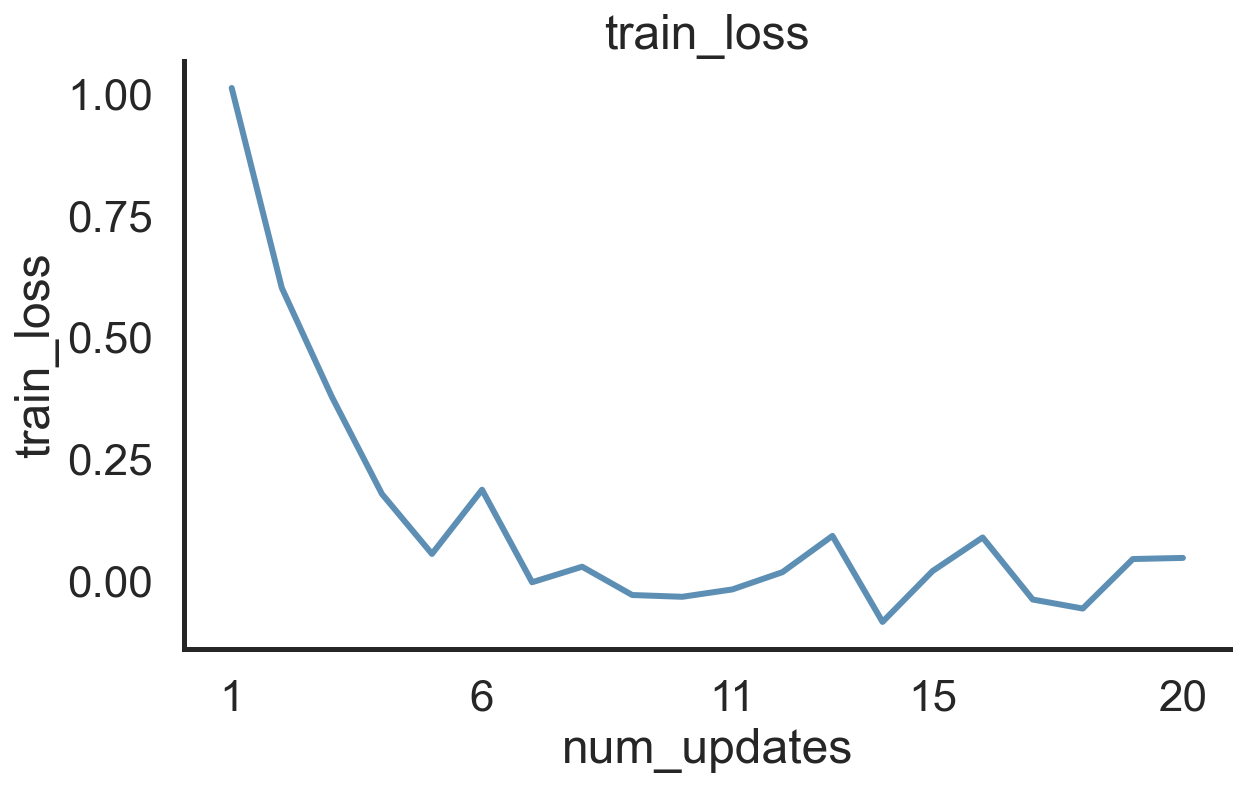

In [52]:
# Load the merged log and aggregate over random seeds (compute stats)
log = load_log(experiment_dir, aggregate_seeds=True)
log.eval_ids, log.stats.train_loss.keys(), log.plot("train_loss", "num_updates")
log.meta

In [ ]:
log.eval_ids

## Log Different Configurations with Different Random Seeds

Next, we can also combine different logs for different hyperparameter configurations and their random seeds. Let's first create two logs for two different configurations:

In [53]:
# Instantiate logging to experiment_dir for two .json configurations and two seeds
log_c1_s1 = MLELogger(time_to_track=['num_updates', 'num_epochs'],
                      what_to_track=['train_loss', 'test_loss'],
                      experiment_dir="multi_config_dir/",
                      config_fname="config_1.json",     
                      seed_id=1)                      

log_c1_s2 = MLELogger(time_to_track=['num_updates', 'num_epochs'],
                      what_to_track=['train_loss', 'test_loss'],
                      experiment_dir="multi_config_dir/",
                      config_fname="config_1.json",
                      seed_id=2)

log_c2_s1 = MLELogger(time_to_track=['num_updates', 'num_epochs'],
                      what_to_track=['train_loss', 'test_loss'],
                      experiment_dir="multi_config_dir/",
                      config_fname="config_2.json",
                      seed_id=1)   

log_c2_s2 = MLELogger(time_to_track=['num_updates', 'num_epochs'],
                      what_to_track=['train_loss', 'test_loss'],
                      experiment_dir="multi_config_dir/",
                      config_fname="config_2.json",
                      seed_id=2)

# Update the logs with collected data & save them to .hdf5
for step in range(20):
    log_c1_s1.update({'num_updates': step+1, 'num_epochs': 0},
                     {'train_loss': np.exp(-0.5*step) + np.random.normal(0, 0.1),
                      'test_loss': np.exp(-0.3*step)  + np.random.normal(0, 0.1)}, save=True)
    log_c1_s2.update({'num_updates': step+1, 'num_epochs': 0},
                     {'train_loss': np.exp(-0.5*step) + np.random.normal(0, 0.1),
                      'test_loss': np.exp(-0.3*step)  + np.random.normal(0, 0.1)}, save=True)
    log_c2_s1.update({'num_updates': step+1, 'num_epochs': 0},
                     {'train_loss': np.exp(-0.5*step) + np.random.normal(0, 0.1),
                      'test_loss': np.exp(-0.3*step)  + np.random.normal(0, 0.1)}, save=True)
    log_c2_s2.update({'num_updates': step+1, 'num_epochs': 0},
                     {'train_loss': np.exp(-0.5*step) + np.random.normal(0, 0.1),
                      'test_loss': np.exp(-0.3*step)  + np.random.normal(0, 0.1)}, save=True)

We can now first merge different random seeds for both configurations (again via `merge_seed_logs`) and then afterwards, combine the seed-aggregated logs for the two configurations via `merge_config_logs`:

In [54]:
# Merge different random seeds for each config into separate .hdf5 file
merge_seed_logs(f"multi_config_dir/config_1/logs/config_1.hdf5", 
                f"multi_config_dir/config_1/")
merge_seed_logs(f"multi_config_dir/config_2/logs/config_2.hdf5", 
                f"multi_config_dir/config_2/")

# Aggregate the different merged configuration .hdf5 files into single meta log
from mle_logging import merge_config_logs
merge_config_logs(experiment_dir="multi_config_dir/",
                  all_run_ids=["config_1", "config_2"])

This meta-log can then again be reloaded via `load_log` and specifying its location:

(['config_1', 'config_2'],
 odict_keys(['mean', 'std', 'p50', 'p10', 'p25', 'p75', 'p90']),
 (<Figure size 648x432 with 1 Axes>,
  <AxesSubplot:title={'center':'train_loss, test_loss'}, xlabel='num_updates', ylabel='train_loss, test_loss'>))

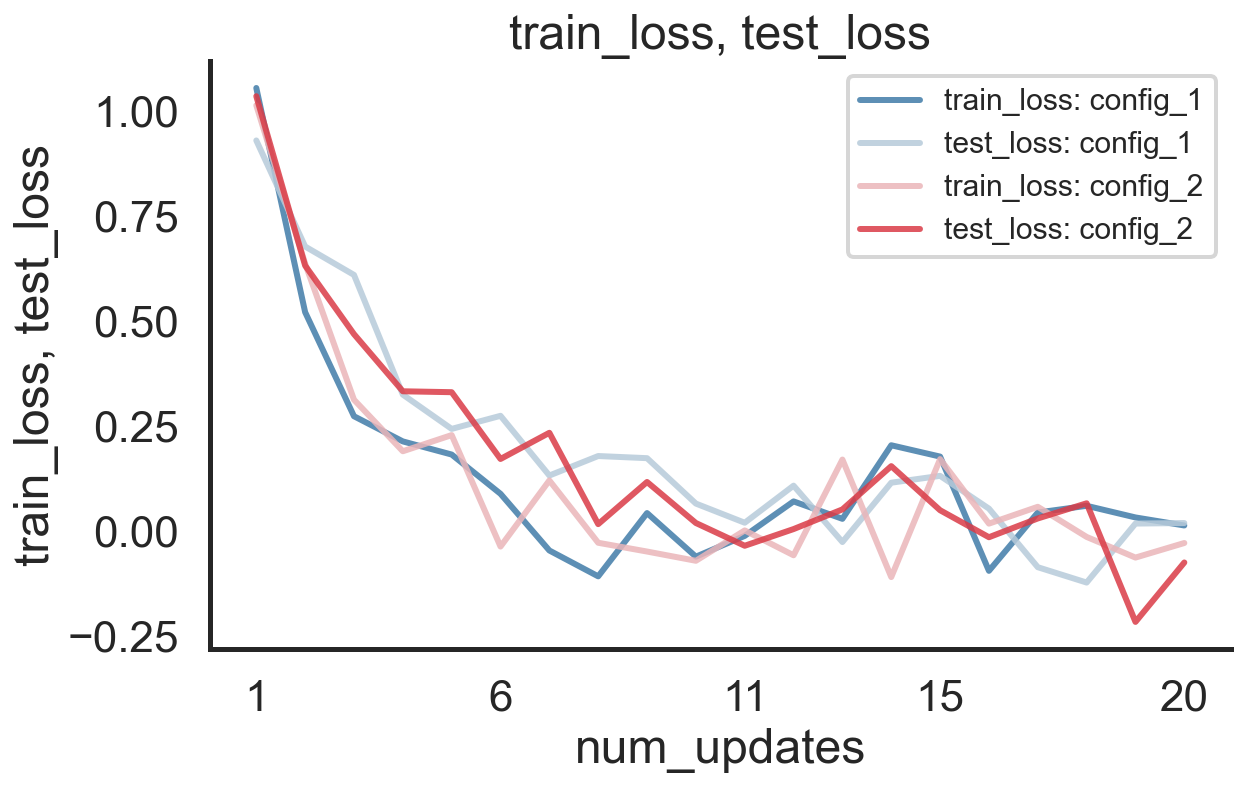

In [55]:
# Afterwards load in the meta log object
meta_log = load_log("multi_config_dir/meta_log.hdf5", aggregate_seeds=True)
meta_log.eval_ids, meta_log.config_1.stats.test_loss.keys(), meta_log.plot(["train_loss", "test_loss"], "num_updates")

Again `load_log` has the option to `aggregate_seeds` or not:

(<Figure size 648x432 with 1 Axes>,
 <AxesSubplot:title={'center':'train_loss, test_loss'}, xlabel='num_updates', ylabel='train_loss, test_loss'>)

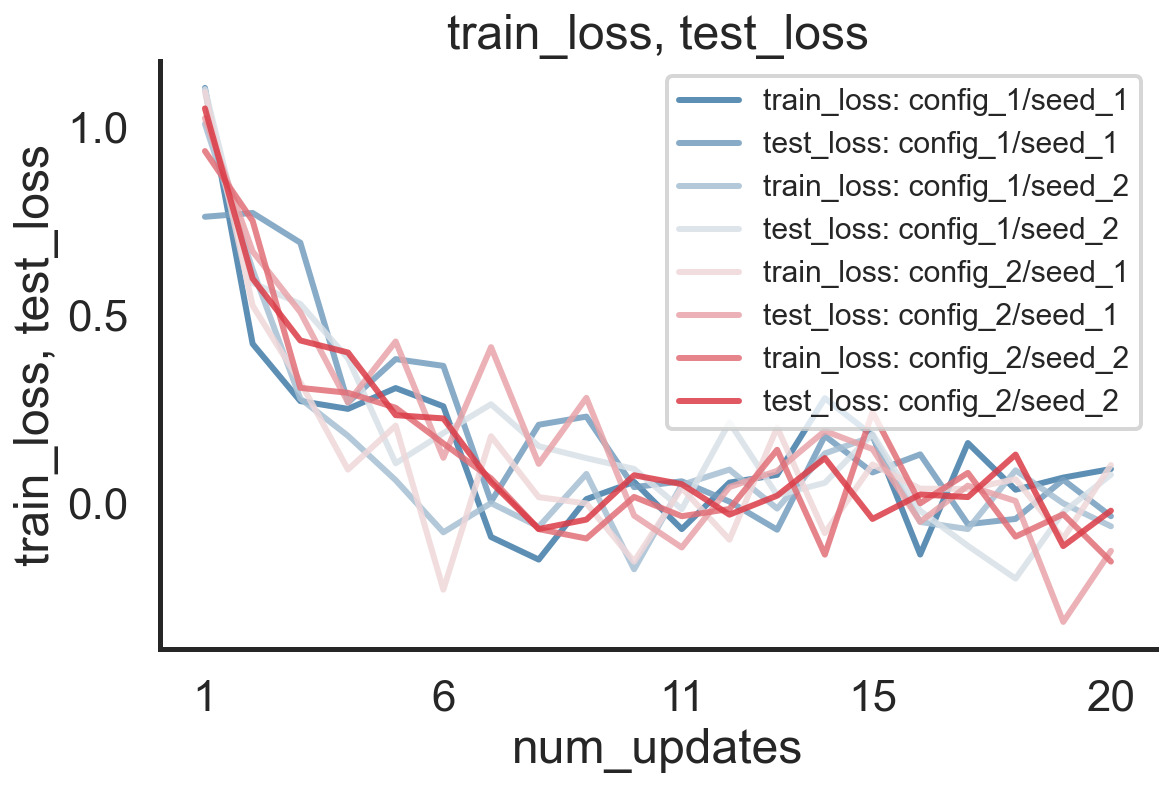

In [56]:
meta_log = load_log("multi_config_dir/meta_log.hdf5", aggregate_seeds=False)
meta_log.eval_ids, meta_log.config_1.keys()
meta_log.plot(["train_loss", "test_loss"], "num_updates")

# Logging Every k-th Checkpoint Update

Next up you can choose to not only store the most recent checkpoint, but to also store every k-th one. Simply specify `save_every_k_ckpt` when instantiating the logger and the toolbox will take care of the archiving:

In [57]:
# Instantiate logging to experiment_dir
log = MLELogger(time_to_track=['num_updates', 'num_epochs'],
                what_to_track=['train_loss', 'test_loss'],
                experiment_dir='every_k_dir/',
                model_type='torch',
                ckpt_time_to_track='num_updates',
                save_every_k_ckpt=2)

In [58]:
time_tic = {'num_updates': 10, 'num_epochs': 1}
log.update(time_tic, stats_tic, model, save=True)

time_tic = {'num_updates': 20, 'num_epochs': 1}
log.update(time_tic, stats_tic, model, save=True)

time_tic = {'num_updates': 30, 'num_epochs': 1}
log.update(time_tic, stats_tic, model, save=True)

time_tic = {'num_updates': 40, 'num_epochs': 1}
log.update(time_tic, stats_tic, model, save=True)

log.model_log.every_k_ckpt_list, log.model_log.every_k_storage_time

(['every_k_dir/models/every_k/every_k_no_seed_provided_k_2.pt',
  'every_k_dir/models/every_k/every_k_no_seed_provided_k_4.pt'],
 [2, 4])

# Logging Top-k Checkpoints Based on Metric

Last but not least we can also choose to keep an archive of the top-k performing networks based on chosen metric. As additional input you have to provide the size of your archive `save_top_k_ckpt`, the metric `top_k_metric_name` and whether to minimize it `top_k_minimize_metric`:

In [59]:
# Instantiate logging to experiment_dir
log = MLELogger(time_to_track=['num_updates', 'num_epochs'],
                what_to_track=['train_loss', 'test_loss'],
                experiment_dir="top_k_dir/",
                model_type='torch',
                ckpt_time_to_track='num_updates',
                save_top_k_ckpt=2,
                top_k_metric_name="test_loss",
                top_k_minimize_metric=True)

In [60]:
time_tic = {'num_updates': 10, 'num_epochs': 1}
stats_tic = {'train_loss': 0.1234, 'test_loss': 0.1235}
log.update(time_tic, stats_tic, model, save=True)

time_tic = {'num_updates': 20, 'num_epochs': 1}
stats_tic = {'train_loss': 0.1234, 'test_loss': 0.11}
log.update(time_tic, stats_tic, model, save=True)

time_tic = {'num_updates': 30, 'num_epochs': 1}
stats_tic = {'train_loss': 0.1234, 'test_loss': 0.09}
log.update(time_tic, stats_tic, model, save=True)

time_tic = {'num_updates': 40, 'num_epochs': 1}
stats_tic = {'train_loss': 0.1234, 'test_loss': 0.12}
log.update(time_tic, stats_tic, model, save=True)

log.model_log.top_k_performance, log.model_log.top_k_storage_time

([0.09, 0.11], [3, 2])

In [61]:
# Reload the previously instantiated logger from the directory
log = MLELogger(time_to_track=['num_updates', 'num_epochs'],
                what_to_track=['train_loss', 'test_loss'],
                experiment_dir="top_k_dir/",
                model_type='torch',
                ckpt_time_to_track='num_updates',
                save_top_k_ckpt=2,
                top_k_metric_name="test_loss",
                top_k_minimize_metric=True,
                reload=True)

log.model_log.top_k_ckpt_list, log.model_log.top_k_storage_time, log.model_log.top_k_performance

(['top_k_dir/models/top_k/top_k_no_seed_provided_top_0.pt',
  'top_k_dir/models/top_k/top_k_no_seed_provided_top_1.pt'],
 [3, 2],
 [0.09000000357627869, 0.10999999940395355])

So this is it. Let me know what you think! If you find a bug or are missing your favourite feature, feel free to contact me [@RobertTLange](https://twitter.com/RobertTLange) or create an issue!